In [256]:
import pandas as pd
import numpy as np
# from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
# from matplotlib.patches import Ellipse
import seaborn as sns

# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer

pd.set_option('display.max_rows', None)     # show all rows
pd.set_option('display.max_columns', None)  # show all columns
pd.set_option('display.width', None)        # no fixed width wrapping
pd.set_option('display.max_colwidth', None) # show full cell content

In [257]:
# params
gw = 38
point_threshold = 2

if gw < 2 or gw > 39: 
    raise ValueError("GW number has to be between 2 and 38")

In [258]:
def peek_df(df, target_col=None):
    print("="*40)
    print("HEAD OF DATAFRAME")
    print("="*40)
    if df.shape[1] > 5:
        print(df.iloc[:, :5].head())
    else:
        print(df.head())

    print("="*40)
    print("SHAPE OF DATAFRAME")
    print("="*40)
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}\n")

    print("="*40)
    print("INFO")
    print("="*40)
    df.info()
    print()

    print("="*40)
    print("MISSING VALUES")
    print("="*40)
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    if not missing.empty:
        missing_percent = (missing / len(df)) * 100
        missing_df = pd.DataFrame({
            "Missing Values": missing,
            "Percent": missing_percent.round(2)
        })
        print(missing_df, "\n")
    else:
        print("No missing values.\n")

    print("="*40)
    print("DESCRIPTIVE STATS (NUMERIC)")
    print("="*40)
    print(df.describe(), "\n")

    print("="*40)
    print("DESCRIPTIVE STATS (CATEGORICAL)")
    print("="*40)
    categorical_cols = df.select_dtypes(include='object').columns
    if len(categorical_cols) > 0:
        print(df[categorical_cols].describe(), "\n")
    else:
        print("No categorical (object) columns to describe.\n")

    print("="*40)
    print("UNIQUE VALUES")
    print("="*40)
    for col in df.columns:
        if df[col].nunique(dropna=True) <= 20:
            print(f"{col}: {df[col].unique()}")

    if target_col:
        print("="*40)
        print(f"TARGET COLUMN DISTRIBUTION: {target_col}")
        print("="*40)
        print(df[target_col].value_counts(), "\n")

        sns.countplot(x=target_col, data=df)
        plt.title(f"Countplot of '{target_col}'")
        plt.show()

        if df.shape[1] <= 35:
            print("="*40)
            print("CORRELATION HEATMAP (NUMERIC FEATURES)")
            print("="*40)
            numeric_df = df.select_dtypes(include=['number'])
            sns.heatmap(numeric_df.corr(), annot=False, cmap="coolwarm", fmt=".2f")
            plt.title("Correlation Heatmap")
            plt.show()

In [259]:
# Read the training and test datasets
df_raw_train = pd.read_csv('../datasets/vaastav/2024_2025/fpl_data_all_gw.csv')

In [260]:
def pick_gw(df, gw):
    common_cols = [col for col in df.columns if not col.startswith('gw')]
    gw_cols = []
    for this_gw in range(1,gw):     # don't include gw itself!
        gw_cols.extend([col for col in df.columns if col.startswith(f'gw{this_gw}_')])
        
    target_col = [f'gw{gw}_total_points']
    selected_cols = common_cols + gw_cols + target_col
    return df[selected_cols].copy()

In [261]:
df_raw_gw = pick_gw(df_raw_train, gw)
df_raw_gw.columns

Index(['element', 'name', 'team', 'position', 'gw1_xP', 'gw1_assists',
       'gw1_bonus', 'gw1_bps', 'gw1_clean_sheets', 'gw1_creativity',
       ...
       'gw37_saves', 'gw37_starts', 'gw37_team_a_score', 'gw37_team_h_score',
       'gw37_threat', 'gw37_total_points', 'gw37_value', 'gw37_was_home',
       'gw37_yellow_cards', 'gw38_total_points'],
      dtype='object', length=1115)

HEAD OF DATAFRAME
   element                          name     team position  gw1_xP
0        1         Fábio Ferreira Vieira  Arsenal      MID     2.3
1        2     Gabriel Fernando de Jesus  Arsenal      FWD     3.2
2        3  Gabriel dos Santos Magalhães  Arsenal      DEF     4.2
3        4                   Kai Havertz  Arsenal      FWD     3.5
4        5                     Karl Hein  Arsenal       GK     0.0
SHAPE OF DATAFRAME
Rows: 615, Columns: 1115

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Columns: 1115 entries, element to gw38_total_points
dtypes: bool(37), float64(333), int64(742), object(3)
memory usage: 5.1+ MB

MISSING VALUES
No missing values.

DESCRIPTIVE STATS (NUMERIC)
          element      gw1_xP  gw1_assists   gw1_bonus     gw1_bps  \
count  615.000000  615.000000   615.000000  615.000000  615.000000   
mean   308.269919    1.528455     0.030894    0.102439    5.486179   
std    178.021314    1.146324     0.173172    0.471581  

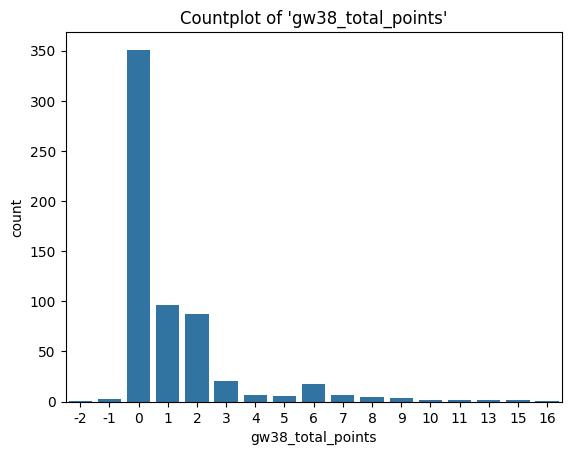

In [262]:
peek_df(df_raw_gw, f'gw{gw}_total_points')

In [263]:
# drop a few columns
df_raw_gw.drop(columns=['element', 'name', 'team'], inplace=True)
gw_cols_to_drop = ['fixture', 'opponent_team', 'value', 'starts', 'was_home', 'penalties_missed', 'penalties_saved', 'red_cards', 'own_goals']
for gw_num in range(1, gw):
    df_raw_gw.drop(columns=[f'gw{gw_num}_{col}' for col in gw_cols_to_drop], inplace=True)

df_raw_gw.drop(columns=df_raw_gw.columns[df_raw_gw.nunique() == 1].to_list(), inplace=True)

In [264]:
df_raw_gw.columns[df_raw_gw.nunique() == 1].to_list()

[]

In [265]:
# split target from feature
target_col = f'gw{gw}_total_points'
X = df_raw_gw.drop(columns=[target_col])

# one-hot encode position column
encoder = OneHotEncoder(sparse_output=False)
pos_encoded = encoder.fit_transform(X[["position"]])
pos_encoded_df = pd.DataFrame(pos_encoded, columns=encoder.get_feature_names_out(["position"]), index=X.index)

# Drop the original position column and join encoded columns
X = pd.concat([pos_encoded_df, X.drop(columns=["position"])], axis=1)

# convert to float
X = X.astype(float).copy()

In [266]:
y = df_raw_gw[[target_col]]
y = (y[f'gw{gw}_total_points'] > point_threshold).astype(int)

In [267]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=8, stratify=y)

In [268]:
# GDA estimates
# ML estimates
phi = (y_train == 1).mean()  # class prior
mu_0 = X_train.loc[y_train == 0].mean(axis=0)
mu_1 = X_train.loc[y_train == 1].mean(axis=0)
sigma = ((X_train - mu_0).T @ (X_train - mu_0)) / len(X_train)

In [269]:
def predict_gda (x, mu_0, mu_1, sigma):
    
    # test GDA on the validation set
    centered_X_0 = (x - mu_0).values
    centered_X_1 = (x - mu_1).values
    inv_sigma = np.linalg.inv(sigma.values)

    exponent_0 = -0.5 * centered_X_0 @ inv_sigma @ centered_X_0.T
    exponent_1 = -0.5 * centered_X_1 @ inv_sigma @ centered_X_1.T

    log_likelihood_0 = exponent_0 + np.log(1 - phi)
    log_likelihood_1 = exponent_1 + np.log(phi)

    prediction = (log_likelihood_1 > log_likelihood_0).astype(int)

    return prediction

int64 int64
Validation Accuracy: 0.56


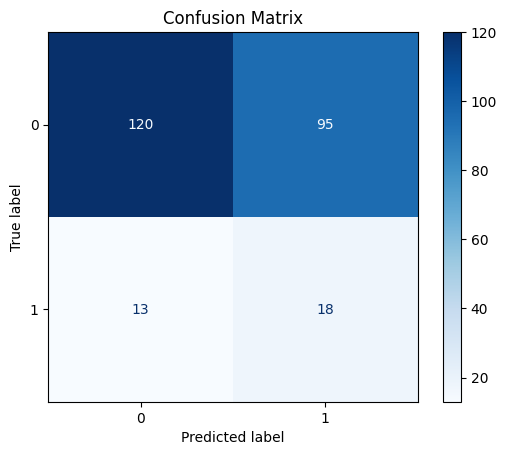

In [270]:
predictions=  []
for x in X_test.values:
    predictions.append(predict_gda(x, mu_0, mu_1, sigma))

y_true = y_test.astype(int).values
preds = np.array(predictions).astype(int)
print(y_true.dtype, preds.dtype)  # both should be int64 now

# Now calculate accuracy
accuracy = np.mean(preds == y_true)
print(f"Validation Accuracy: {accuracy:.2f}")

# Confusion matrix
cm = confusion_matrix(y_true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [271]:
# sns.heatmap(sigma.corr(), annot=False, cmap="coolwarm", fmt=".2f")
# plt.title("Correlation Heatmap")
# plt.show()

In [272]:
cm

array([[120,  95],
       [ 13,  18]])